## RAG + Image Generator Agent : 보고서작성 with DALL-E

이번에는 Web Search, PDF문서 기반 검색(RAG), 이미지생성(Image Generator) 등을 통해 보고서를 작성하는 에이전트를 만들어볼것이다.

- Source
    - [Agent Toolkits](https://api.python.langchain.com/en/latest/community/agent_toolkits.html)
    - [Tools](https://python.langchain.com/docs/integrations/tools/)

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain_teddynote import logging

logging.langsmith("agent_report_with_image_generation")

LangSmith 추적을 시작합니다.
[프로젝트명]
agent_report_with_image_generation


### 도구 정의
#### 웹 검색 도구 : TavilySearch

Langchain에서는 Tavily 검색엔진을 도구로 쉽게 사용할 수 있는 내장도구가 있다.
Tavily Search를 사용하기 위해서 API Key를 발급받아 `.env` 파일에 저장해야한다.
- [Tavily Search](https://app.tavily.com/home?code=LBClK7Jit5qjF80ghXp0URHz4txTFLfohLv-p3eRWpm4n&state=eyJyZXR1cm5UbyI6Ii9ob21lIn0)
- `TAVILY_API_KEY=발급 받은 Tavily API KEY 입력`

In [4]:
from langchain_community.tools.tavily_search import TavilySearchResults

# 검색엔진 객체 생성
tavily_search = TavilySearchResults(k=5)


#### 문서 기반 검색 도구 : Retriever

우리가 가진 데이터에 대해 조회를 수행할 retriever도 생성한다.

**실습에 활용한 문서**
소프트웨어정책연구소(SPRi) - 2023년 12월호
- 저자: 유재흥(AI정책연구실 책임연구원), 이지수(AI정책연구실 위촉연구원)
- 링크: https://spri.kr/posts/view/23669
- 파일명: SPRI_AI_Brief_2023년12월호_F.pdf

링크로 들어가 문서를 다운받고 `docs` 폴더에 저장한다.

여기서 PDF문서를 `FAISS` DB에 저장하고 조회하는 Retriever를 생성하고, retriever 를 기반으로 도구를 생성합니다.
먼저, 문서를 로드하고, 분할한 뒤 retriever 를 생성한다.

In [17]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_community.embeddings import JinaEmbeddings
from langchain.document_loaders import PyMuPDFLoader
import os

# PDF 파일로드, 파일 경로 입력
loader = PyMuPDFLoader("docs/SPRI_AI_Brief_2023년12월호_F.pdf")


# 텍스트 분할
text_splitter = RecursiveCharacterTextSplitter(chunk_size = 1000, chunk_overlap = 100)

# 문서로드 및 분할
split_docs = loader.load_and_split(text_splitter)

# vectorstore 생성
# JinaEmbeddings
# embeddings_model = JinaEmbeddings(
#     model_name= "jinaai/jina-embeddings-v3",
#     jina_api_key=os.environ["JINA_API_KEY"]
# )
# Jina 모델을 이용한 vectorstore 생성
# vectorstore = FAISS.from_documents(split_docs, embeddings_model)


# OpenAIEmbeddings
vectorstore = FAISS.from_documents(split_docs, OpenAIEmbeddings())

# retriever 생성
retriever = vectorstore.as_retriever()

retriever

VectorStoreRetriever(tags=['FAISS', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x157e498b0>, search_kwargs={})

다음은 retriever을 이용해 도구로 정의한다.
이때 `document_prompt`는 문서의 내용을 표시하는 템플릿을 정의한다.

- 기본갑은 문서의 `page_content`만 표기
- 문서의 페이지 번호나 출처 등을 표시하기 위해서는 템플릿을 따로 정의해야한다.

In [23]:
from langchain.tools.retriever import create_retriever_tool
from langchain_core.prompts import PromptTemplate

# 문서의 내용을 표시하는 템플릿 정의
document_prompt = PromptTemplate.from_template(
"<document><content>{page_content}</content><page>{page}</page><filename>{source}</filename></document>"
)

# retriever 도구 정의
retriever_tool = create_retriever_tool(
    retriever,
    name="pdf_search",
    description="use this tool to search for information in the PDF file",
    document_prompt=document_prompt,
)
retriever_tool

Tool(name='pdf_search', description='use this tool to search for information in the PDF file', args_schema=<class 'langchain_core.tools.retriever.RetrieverInput'>, func=functools.partial(<function _get_relevant_documents at 0x117d92160>, retriever=VectorStoreRetriever(tags=['FAISS', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x157e498b0>, search_kwargs={}), document_prompt=PromptTemplate(input_variables=['page', 'page_content', 'source'], input_types={}, partial_variables={}, template='<document><content>{page_content}</content><page>{page}</page><filename>{source}</filename></document>'), document_separator='\n\n', response_format='content'), coroutine=functools.partial(<function _aget_relevant_documents at 0x117d927a0>, retriever=VectorStoreRetriever(tags=['FAISS', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x157e498b0>, search_kwargs={}), document_prompt=PromptTemplate(input_variables=['page'

In [25]:
print(retriever_tool.invoke("삼성전자가 개발한 `생성형 AI` 에 대한 정보를 찾아주세요."))

<document><content>SPRi AI Brief |  
2023-12월호
10
삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개
n 삼성전자가 온디바이스에서 작동 가능하며 언어, 코드, 이미지의 3개 모델로 구성된 자체 개발 생성 
AI 모델 ‘삼성 가우스’를 공개
n 삼성전자는 삼성 가우스를 다양한 제품에 단계적으로 탑재할 계획으로, 온디바이스 작동이 가능한 
삼성 가우스는 외부로 사용자 정보가 유출될 위험이 없다는 장점을 보유
KEY Contents
£ 언어, 코드, 이미지의 3개 모델로 구성된 삼성 가우스, 온디바이스 작동 지원
n 삼성전자가 2023년 11월 8일 열린 ‘삼성 AI 포럼 2023’ 행사에서 자체 개발한 생성 AI 모델 
‘삼성 가우스’를 최초 공개
∙정규분포 이론을 정립한 천재 수학자 가우스(Gauss)의 이름을 본뜬 삼성 가우스는 다양한 상황에 
최적화된 크기의 모델 선택이 가능
∙삼성 가우스는 라이선스나 개인정보를 침해하지 않는 안전한 데이터를 통해 학습되었으며, 
온디바이스에서 작동하도록 설계되어 외부로 사용자의 정보가 유출되지 않는 장점을 보유
∙삼성전자는 삼성 가우스를 활용한 온디바이스 AI 기술도 소개했으며, 생성 AI 모델을 다양한 제품에 
단계적으로 탑재할 계획
n 삼성 가우스는 △텍스트를 생성하는 언어모델 △코드를 생성하는 코드 모델 △이미지를 생성하는 
이미지 모델의 3개 모델로 구성
∙언어 모델은 클라우드와 온디바이스 대상 다양한 모델로 구성되며, 메일 작성, 문서 요약, 번역 업무의 
처리를 지원
∙코드 모델 기반의 AI 코딩 어시스턴트 ‘코드아이(code.i)’는 대화형 인터페이스로 서비스를 제공하며 
사내 소프트웨어 개발에 최적화
∙이미지 모델은 창의적인 이미지를 생성하고 기존 이미지를 원하는 대로 바꿀 수 있도록 지원하며 
저해상도 이미지의 고해상도 전환도 지원
n IT 전문지 테크리퍼블릭(TechRepublic)은 온디바이스 AI가 주요 기술 트렌드로 부상했다며,</content><page>12

#### Image Generator 도구 : DALL-E 

DALL-E 도구는 이미지를 생성하는 도구이다.

**Element**
- `model` : 모델이름(기본값 : "dall-e-2", "dall-e-3")
- `n` : 생성할 이미지 수 (기본값 : 1)
- `size` : 이미지 크기
    - "dall-e-2": "1024x1024", "512x512", "256x256"
    - "dall-e-3": "1024x1024", "1792x1024", "1024x1792"
- `style` : 이미지 스타일 (기본값 : "natural", "vivid")
- `quality` : 이미지 품질 (기본값 : "standard", "hd")
- `max_retries` : 최대 재시도 횟수 

In [40]:
from langchain_community.utilities.dalle_image_generator import DallEAPIWrapper
from langchain.tools import tool
# Dall-e api wrapper 생성
dalle = DallEAPIWrapper(
    model="dall-e-3", 
    size="1024x1024", 
    quality = "standard", 
    n = 1
)

# Dall-E API Wrapper도구 정의
@tool
def dalle_tool(query:str):
    """use this tool to generate image from text"""
    return dalle.run(query)

dalle_tool



StructuredTool(name='dalle_tool', description='use this tool to generate image from text', args_schema=<class 'langchain_core.utils.pydantic.dalle_tool'>, func=<function dalle_tool at 0x149b8b4c0>)

#### 파일관리 도구 : FileManagementToolkits

**파일 관리 도구들**
- `CopyFileTool` : 파일 복사
- `DeleteFileTool` : 파일 삭제
- `FileSearchTool` : 파일 검색
- `MoveFileTool` : 파일 이동
- `ReadFileTool` : 파일 읽기
- `WriteFileTool` : 파일 쓰기
- `ListDirectoryTool` : 디렉토리 목록 조회




In [33]:
from langchain_community.agent_toolkits import FileManagementToolkit

# 작업할 디렉토리 경로
toolkit_directory = "tmp"

# 파일 관리 도구 생성 (쓰기, 읽기, 목록 조회)
file_tools = FileManagementToolkit(
    root_dir = str(toolkit_directory),
    # root_dir = toolkit_directory,
    selected_tools = ["write_file", "read_file", "list_directory"]
).get_tools()
file_tools


[WriteFileTool(root_dir='tmp'),
 ReadFileTool(root_dir='tmp'),
 ListDirectoryTool(root_dir='tmp')]

#### 도구 종합하기 : 웹검색(tavily), 문서검색(retriever), 이미지생성(dalle), 파일관리(toolkit)

이제 모든 도구를 종합하여 에이전트를 생성한다.

In [41]:
tools = file_tools + [ 
    tavily_search,
    retriever_tool,
    dalle_tool
]

tools

[WriteFileTool(root_dir='tmp'),
 ReadFileTool(root_dir='tmp'),
 ListDirectoryTool(root_dir='tmp'),
 TavilySearchResults(api_wrapper=TavilySearchAPIWrapper(tavily_api_key=SecretStr('**********'))),
 Tool(name='pdf_search', description='use this tool to search for information in the PDF file', args_schema=<class 'langchain_core.tools.retriever.RetrieverInput'>, func=functools.partial(<function _get_relevant_documents at 0x117d92160>, retriever=VectorStoreRetriever(tags=['FAISS', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x157e498b0>, search_kwargs={}), document_prompt=PromptTemplate(input_variables=['page', 'page_content', 'source'], input_types={}, partial_variables={}, template='<document><content>{page_content}</content><page>{page}</page><filename>{source}</filename></document>'), document_separator='\n\n', response_format='content'), coroutine=functools.partial(<function _aget_relevant_documents at 0x117d927a0>, retriever=VectorStoreRet

tools를 검색해보면 미리 설정해 둔 웹검색, 문서검색, 이미지생성, 파일관리 도구가 모두 포함되어있음을 확인할 수 있다.

### Agent 생성

이제 만들어 놓은 도구를 포함하여 에이전트를 생성한다.

In [35]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain.agents import create_tool_calling_agent, AgentExecutor
from langchain_community.chat_message_histories import ChatMessageHistory
from langchain_openai import ChatOpenAI
from langchain_teddynote.messages import AgentStreamParser

# session_id 저장할 딕셔너리
store = {}

# prompt 생성 : 모델이 수행할 작업을 설명 (도구의 이름과 역할입력)
prompt = ChatPromptTemplate.from_messages([
    (
        "system",
        "You are a helpful assistant."
        "YOu are a professional researcher."
        "You can use the 'pdf_search' tool to search for information in the PDF file"
        "You can find further information by using 'TavilySearchResults' tool for web search"
        "you can use image generation 'dalle_tool' tool to generate image from text"
        "Finaly, you can use 'file management' tool to save your research result into files. "
    ),
    ("placeholder", "{chat_history}"),
    ("human", "{input}"),
    ("placeholder", "{agent_scratchpad}")
])

# LLM 생성
llm = ChatOpenAI(model="gpt-4o-mini")

# agent 생성
agent = create_tool_calling_agent(llm, tools, prompt)

# AgentExecutor 생성
agent_executor = AgentExecutor(
    agent = agent,
    tools = tools,
    verbose = False,
    handle_parsing_errors=True,
)

# session_id 기반의 세션기록을 가져오는 함수
def get_session_history(session_ids):
    if session_ids not in store : 
        store[session_ids] = ChatMessageHistory()
    return store[session_ids]

# 채팅 메세지 기록이 추가된 agent생성
agent_with_chat_history = RunnableWithMessageHistory(
    agent_executor,
    get_session_history=get_session_history,
    input_messages_key="input",
    history_messages_key="chat_history"
)

# 스트림 파서 생성
agent_stream_parser = AgentStreamParser()

### Agent 실행

도구들을 만들어 Agent를 생성하였으니, 이제 에이전트를 실행해보자.

In [36]:
result = agent_with_chat_history.stream(
    {
        "input" : "삼성전자가 개발한 `생성형 AI` 에 대한 정보를 pdf 문서에서 찾아 bullet point로 정리해주세요."
        "한글로 작성하세요."
        "다음으로는 `report.md` 파일을 새롭게 생성하여 정리한 내용을 저장해주세요.\n\n"
        "[작성방법]\n"
        "1. markdown header 2 크기로 적절한 제목을 작성하세요.\n"
        "2. 발췌한 PDF문서의 페이지 번호, 파일명도함께 기입하세요.(예시 : page 10, filename.pdf)\n"
        "3. 정리된 bullet point를 작성하세요.\n"
        "4. 작성이 완료되면 파일을 `report.md` 파일로 저장해주세요.\n"
        "5. 마지막으로 저장한 `report.md`파일을 읽어서 출력하세요."
    },
    config = {"configurable": {"session_id": "ruah0807"}}
)
print("result : ")
for step in result :
    agent_stream_parser.process_agent_steps(step)

result : 
[도구 호출]
Tool: pdf_search
query: 삼성전자 생성형 AI
Log: 
Invoking: `pdf_search` with `{'query': '삼성전자 생성형 AI'}`



[관찰 내용]
Observation: <document><content>SPRi AI Brief |  
2023-12월호
10
삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개
n 삼성전자가 온디바이스에서 작동 가능하며 언어, 코드, 이미지의 3개 모델로 구성된 자체 개발 생성 
AI 모델 ‘삼성 가우스’를 공개
n 삼성전자는 삼성 가우스를 다양한 제품에 단계적으로 탑재할 계획으로, 온디바이스 작동이 가능한 
삼성 가우스는 외부로 사용자 정보가 유출될 위험이 없다는 장점을 보유
KEY Contents
£ 언어, 코드, 이미지의 3개 모델로 구성된 삼성 가우스, 온디바이스 작동 지원
n 삼성전자가 2023년 11월 8일 열린 ‘삼성 AI 포럼 2023’ 행사에서 자체 개발한 생성 AI 모델 
‘삼성 가우스’를 최초 공개
∙정규분포 이론을 정립한 천재 수학자 가우스(Gauss)의 이름을 본뜬 삼성 가우스는 다양한 상황에 
최적화된 크기의 모델 선택이 가능
∙삼성 가우스는 라이선스나 개인정보를 침해하지 않는 안전한 데이터를 통해 학습되었으며, 
온디바이스에서 작동하도록 설계되어 외부로 사용자의 정보가 유출되지 않는 장점을 보유
∙삼성전자는 삼성 가우스를 활용한 온디바이스 AI 기술도 소개했으며, 생성 AI 모델을 다양한 제품에 
단계적으로 탑재할 계획
n 삼성 가우스는 △텍스트를 생성하는 언어모델 △코드를 생성하는 코드 모델 △이미지를 생성하는 
이미지 모델의 3개 모델로 구성
∙언어 모델은 클라우드와 온디바이스 대상 다양한 모델로 구성되며, 메일 작성, 문서 요약, 번역 업무의 
처리를 지원
∙코드 모델 기반의 AI 코딩 어시스턴트 ‘코드아이(code.i)’는 대화형 인터페이스로 서비스를 제공하며 
사내 소프트웨어 개발에 최적화
∙이미지 모델은 창의적인

생성된 보고서의 내용을 보면 다음과 같이 작성되었다.
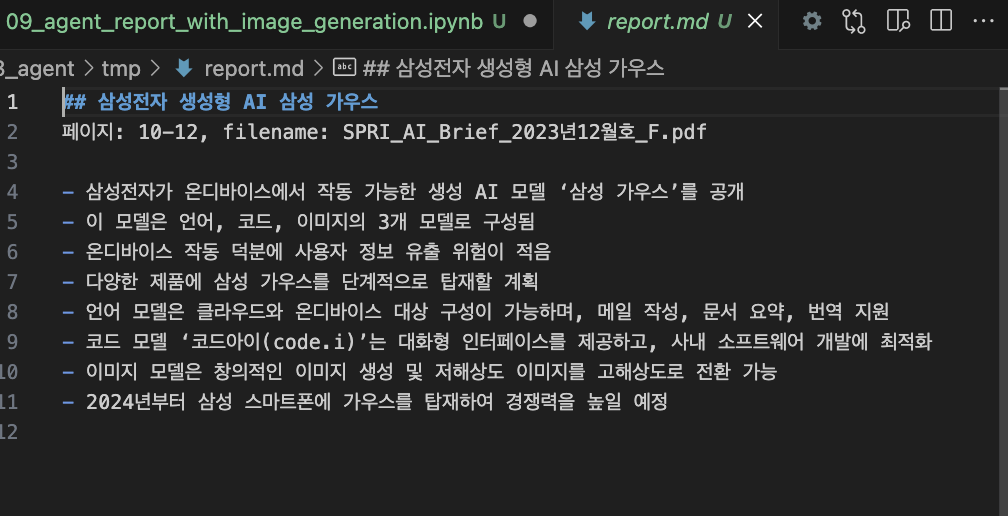

다음으로는 웹 검색을 통해 보고서 파일을 업데이트 해보자.

In [37]:
# 웹 검색을 통해 보고서 파일 업데이트
result = agent_with_chat_history.stream(
    {
        "input": "이번에는 삼성전자가 개발한 `생성형 AI` 와 관련된 정보들을 웹 검색하고, 검색한 결과를 정리해 주세요. "
        "한글로 작성해주세요."
        "다음으로는 `report.md` 파일을 열어서 기존의 내용을 읽고, 웹 검색하여 찾은 정보를 이전에 작성한 형식에 맞춰 뒷 부분에 추가해 주세요. \n\n"
        "#작성방법: \n"
        "1. markdown header 2 크기로 적절한 제목을 작성하세요. \n"
        "2. 정보의 출처(url)를 기입하세요(예시: 출처: 네이버 지식백과). \n"
        "3. 정리된 웹검색 내용을 작성하세요. \n"
        "4. 작성이 완료되면 파일을 `report.md` 에 저장하세요. \n"
        "5. 마지막으로 저장한 `report.md` 파일을 읽어서 출력해 주세요. \n"
    },
    config={"configurable": {"session_id": "ruah0807"}},
)

print("Agent 실행 결과:")
for step in result:
    agent_stream_parser.process_agent_steps(step)

Agent 실행 결과:
[도구 호출]
Tool: tavily_search_results_json
query: 삼성전자 생성형 AI
Log: 
Invoking: `tavily_search_results_json` with `{'query': '삼성전자 생성형 AI'}`



[관찰 내용]
Observation: [{'url': 'https://www.yna.co.kr/view/AKR20231108041400003', 'content': "삼성전자[005930]가 자체 개발한 생성형 인공지능(AI) 모델 '삼성 가우스'(Samsung Gauss)가 처음 공개됐다. 삼성전자는 삼성 가우스를 활용해 임직원의 업무 생산성을 높이는 한편, 생성형 AI 모델을 단계적으로 제품에 탑재해 새로운 사용자 경험을 제공한다는 계획이다."}, {'url': 'https://namu.wiki/w/삼성+가우스', 'content': '삼성 가우스(Samsung Gauss)는 삼성전자의 생성형 인공지능 모델이다. 클라우드와 온디바이스를 위한 여러 생성형 AI 모델이 묶인 초거대 생성형 AI모델 패밀리로, 생성형 AI 모델과 어시스턴트로 이루어져 있다. 이름은 세상의 모든 현상과 지식을 담고, 삼성이 추구하는 생성형 AI의 무한한 가능성을 뜻한다.'}, {'url': 'https://zdnet.co.kr/view/?no=20241121083205', 'content': '또한 "삼성전자 고유의 생성형 AI 모델인 \'삼성 가우스2\'를 공개하고, 향상된 성능과 효율, 그리고 활용 방안에 대해 설명할 예정"이라며 "이를 통해 업무 생산성 향상과 단계적 제품 적용으로 더욱 편리하고 차별화된 고객 경험을 제공할 것"이라고 말했다. 삼성전자는 키노트 발표에서 지난해 처음 공개한 생성형 AI 모델 \'삼성 가우스1(Samsung Gauss1)\'의 후속 모델인 \'삼성 가우스2(Samsung Gauss2)\'를 공개했다. 실제로 \'삼성 가우스\'는 이런 맞춤형 개발의 장점을 살려 직원들의 다양한 

이제 웹 검색을 통해 보고서 파일을 업데이트 하자.

In [38]:
# 보고서 작성을 요청합니다.
result = agent_with_chat_history.stream(
    {
        "input": "`report.md` 파일을 열어서 안의 내용을 출력하세요. "
        "출력된 내용을 바탕으로, 전문적인 수준의 보고서를 작성하세요. "
        "보고서는 총 3개의 섹션으로 구성되어야 합니다:\n"
        "1. 개요: 보고서 abstract 를 300자 내외로 작성하세요.\n"
        "2. 핵심내용: 보고서의 핵심 내용을 작성하세요. 정리된 표를 markdown 형식으로 작성하여 추가하세요. "
        "3. 최종결론: 보고서의 최종 결론을 작성하세요. 출처(파일명, url 등)을 표시하세요."
        "마지막으로 작성된 결과물을 `report-2.md` 파일에 저장하세요."
    },
    config={"configurable": {"session_id": "ruah0807"}},
)

print("Agent 실행 결과:")
for step in result:
    agent_stream_parser.process_agent_steps(step)

Agent 실행 결과:
[도구 호출]
Tool: read_file
file_path: report.md
Log: 
Invoking: `read_file` with `{'file_path': 'report.md'}`



[관찰 내용]
Observation: ## 삼성전자 생성형 AI 삼성 가우스
페이지: 10-12, filename: SPRI_AI_Brief_2023년12월호_F.pdf

- 삼성전자가 온디바이스에서 작동 가능한 생성 AI 모델 ‘삼성 가우스’를 공개
- 이 모델은 언어, 코드, 이미지의 3개 모델로 구성됨
- 온디바이스 작동 덕분에 사용자 정보 유출 위험이 적음
- 다양한 제품에 삼성 가우스를 단계적으로 탑재할 계획
- 언어 모델은 클라우드와 온디바이스 대상 구성이 가능하며, 메일 작성, 문서 요약, 번역 지원
- 코드 모델 ‘코드아이(code.i)’는 대화형 인터페이스를 제공하고, 사내 소프트웨어 개발에 최적화
- 이미지 모델은 창의적인 이미지 생성 및 저해상도 이미지를 고해상도로 전환 가능
- 2024년부터 삼성 스마트폰에 가우스를 탑재하여 경쟁력을 높일 예정
## 삼성전자 생성형 AI 관련 웹 검색 정보
출처: https://www.yna.co.kr/view/AKR20231108041400003
- 삼성전자가 개발한 생성형 인공지능 모델 ‘삼성 가우스’가 공개됨.
- 이 모델은 직원의 업무 생산성을 높이고, 제품에 단계적으로 탑재해 새로운 사용자 경험을 제공할 계획임.

출처: https://namu.wiki/w/삼성+가우스
- 삼성 가우스는 클라우드와 온디바이스를 위한 여러 생성형 AI 모델이 묶인 초거대 생성형 AI 모델 패밀리로, 생성형 AI 모델과 어시스턴트로 이루어져 있음.
- 삼성 가우스는 사용자에게 무한한 가능성을 의미함.

출처: https://zdnet.co.kr/view/?no=20241121083205
- 삼성전자가 삼성 가우스2를 공개하고, 향상된 성능과 효율을 자랑함.
- 문서 요약, 번역, 메일 작성 등을 지원하

마지막으로, 보고서 내용을 기반으로 이미지 생성을 요청하자.

In [43]:
# 이미지 생성을 요청합니다.
result = agent_with_chat_history.stream(
    {
        "input": "`report-2.md` 파일을 열어서 안의 내용을 출력하세요. "
        "출력된 내용에 어울리는 이미지를 생성하세요. "
        "생성한 이미지의 url 을 markdown 형식으로 보고서의 가장 상단에 추가하세요. "
        "마지막으로 작성된 결과물을 `report-3.md` 파일에 저장하세요."
    },
    config={"configurable": {"session_id": "ruah0807"}},
)

print("Agent 실행 결과:")
for step in result:
    agent_stream_parser.process_agent_steps(step)

Agent 실행 결과:
[도구 호출]
Tool: read_file
file_path: report-2.md
Log: 
Invoking: `read_file` with `{'file_path': 'report-2.md'}`



[관찰 내용]
Observation: # 삼성전자 생성형 AI 보고서

## 1. 개요
본 보고서는 삼성전자가 개발한 생성형 AI 모델인 ‘삼성 가우스’에 대한 정보를 종합적으로 정리한 문서입니다. 삼성 가우스는 다양한 생성형 AI 기술을 기반으로 한 초거대 AI 모델로, 온디바이스에서 작동하여 사용자 정보의 보안을 강화하고, 업무 생산성 향상 및 새로운 사용자 경험을 제공할 수 있는 잠재력을 지니고 있습니다.

## 2. 핵심내용
아래는 삼성 가우스에 대한 주요 정보 및 특징입니다.

| 항목 | 내용 |
|------|------|
| **모델 이름** | 삼성 가우스 |
| **구성 모델** | 언어, 코드, 이미지 모델 |
| **온디바이스 작동** | 사용자 정보 유출 방지 |
| **주요 기능** | 메일 작성, 문서 요약, 번역, 이미지 생성 및 변환 |
| **전략** | 2024년부터 다양한 제품에 단계적으로 탑재 |
| **목표** | 업무 생산성 향상 및 새로운 사용자 경험 제공 |
| **공식 포럼 발표** | 삼성 AI 포럼에서 최초 공개 |

## 3. 최종결론
삼성전자의 생성형 AI인 ‘삼성 가우스’는 온디바이스 기술을 통해 사용자 정보를 안전하게 보호하면서도 높은 생산성을 추구할 수 있는 혁신적인 솔루션입니다. 이러한 접근은 향후 다양한 삼성 제품에 통합되어 새로운 사용자 경험을 가능하게 할 것입니다. 이 AI 모델은 회사의 업무 혁신을 추진하며, 삼성전자가 기술 시장에서 더욱 경쟁력을 높이는 데 기여할 것으로 기대됩니다. 

### 출처
- 파일명: SPRI_AI_Brief_2023년12월호_F.pdf
- 웹 검색: [연합뉴스](https://www.yna.co.kr/view/AKR20231108041400